# OOI Arrays: Overview and Context for CHLA Profiling
**Author:** Eli Holmes (NOAA)</br>
Last updated: Dec 5, 2025

The [Ocean Observatories Initiative (OOI)](https://oceanobservatories.org/) is a long-term, NSF-funded ocean observing program designed to provide continuous, high-resolution measurements across key regions of the global and coastal ocean.  
OOI systems collect physical, chemical, biological, and geological observations using a combination of:

- **Moorings: fixed location** (surface, mid-water, deep-water) — These are sensors at fixed discrete depths. CHLA is available only at those specific depths.

- **Depth Profiler systems: fixed location**  
  - **Wire-following profilers (WFPs)** — Provide high-resolution vertical depth profiles, sampling repeatedly up and down the water column.  
  - **Shallow profilers (SPs)** — Motorized profilers delivering dense CHLA depth profiles in the 0-200m range, often with higher sampling frequency than WFPs.  
  - **Deep profilers (DPs)** — Provide deep water (> 200m) vertical profiles.

- **Autonomous gliders: moving location** — Mobile platforms that execute repeated sawtooth depth profiles and produce full vertical CHLA measurements for each dive.

Across these platforms, OOI instruments collect high-frequency, vertically resolved biological measurements, including:
chlorophyll-a concentration, particulate organic matter & phytoplankton biomass, colored dissolved organic matter (CDOM), photosynthetically available radiation (PAR), sea water physical properties (temperature, salinity, and density), dissolved oxygen, nitrate, pH, pCO₂.  We are interested in modeling CHLA vertical depth profiles and will focus on the chlorophyll-a concentration measurement. OOI data is openly available through the OOI Data Portal and ERDDAP servers.


![](Supporting_files/ooi.jpg)



## OOI Regional Arrays

OOI consists of **two major coastal arrays**, a **regional cabled array**, and **four global open-ocean arrays**. Coastal arrays sample continental shelf, slope, and upwelling environments that exhibit strong seasonal biological and physical variability. These sites typically include vertically profiling platforms that provide **full or partial CHLA depth profiles** in the upper 0–200 m. Global Arrays observe key climate-relevant open-ocean regions and generally **do not include vertical profilers**, but they do provide **CHLA at fixed depths** within the 0–200 m zone, which can still be mapped into depth bins.

1. **Coastal Stations:**
    - **Endurance Array (Oregon & Washington)** — Samples an eastern boundary upwelling system across nearshore, shelf, and offshore environments. Platforms include surface and subsurface moorings (fixed-depth CHLA), **wire-following profilers** (0–200 m), **cabled shallow/deep profilers**, and autonomous gliders (0–200+ m profiles).
    - **Pioneer Array (Northwest Atlantic / Mid-Atlantic Bight)** — Observes cross-shelf and shelf-break frontal systems with strong biological gradients. Platforms include multi-tier moorings, surface buoys, gliders, and (in most years) **shallow profilers** that provided high-resolution 0–200 m CHLA profiles.
    - **Regional Cabled Array (Washington–Oregon offshore)** — Provides real-time power and data to offshore slope and deepwater nodes. Only the **cabled shallow profilers** contribute 0–200 m CHLA profiles; most deep or seafloor instruments do not sample CHLA.

2. **Global Stations:**
    - **Papa Array (Gulf of Alaska)** — Subarctic gyre; CHLA sensors at fixed depths (typically 7–50 m).
    - **Irminger Sea Array (Greenland–Iceland region)** — High-latitude convection region; CHLA at fixed depths in the upper 100 m.
    - **Argentine Basin Array (Southwest Atlantic)** — Deep-ocean circulation site; limited CHLA at one or two fixed depths (~30 m).
    - **Southern Ocean Array (South of Tasmania)** — High-mixing Southern Ocean environment; CHLA measurements at fixed depths in the upper 50 m.



## Workflow

This notebook processes CHLA data from OOI platforms showing:

- automated ERDDAP retrieval,  
- daily depth-binned CHLA profiles,  
- merged datasets across platforms and regions.

We work with a set of Endurance platforms listed in `endurance_dict`, including:

- **Offshore and shelf surface moorings** (near-surface instrument frames with fluorometers)
- **Cabled shallow and deep profilers**
- **Wire-following profilers** on offshore moorings
- **Inshore and shelf surface-piercing profilers**

For each platform, we:

1. Request CHLA data from the OOI ERDDAP server.
2. Process the data into **daily mean CHLA profiles** in fixed 10 m depth bins between 0 and 200 m.
3. Save per-platform parquet files and then merge them into a single, combined Endurance dataset.
4. Plot example CHLA–depth profiles for individual daily "profiles" (platform × day).


## Inspect ERDDAP variables for a single Endurance instrument

First, inspect the available variables for one representative dataset on the OOI ERDDAP server.  
This helps confirm the exact variable names for chlorophyll-a and related quality-control flags before building generalized code.


In [24]:
# See the variables
import pandas as pd
base = "https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap"
dataset_id = "ooi-ce04osps-sf01b-3a-flortd104"
header_url = f"{base}/{dataset_id}.csv?"
# read only the header, skip the units row
df0 = pd.read_csv(header_url, skiprows=[1], nrows=0)
print(df0.columns)

Index(['time', 'latitude', 'longitude', 'z',
       'concentration_of_colored_dissolved_organic_matter_in_sea_water_expressed_as_equivalent_mass_fraction_of_quinine_sulfate_dihydrate_profiler_depth_enabled',
       'concentration_of_colored_dissolved_organic_matter_in_sea_water_expressed_as_equivalent_mass_fraction_of_quinine_sulfate_dihydrate_profiler_depth_enabled_qc_agg',
       'concentration_of_colored_dissolved_organic_matter_in_sea_water_expressed_as_equivalent_mass_fraction_of_quinine_sulfate_dihydrate_profiler_depth_enabled_qc_tests',
       'mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled',
       'mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_agg',
       'mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_tests',
       'depth_reading_profiler_depth_enabled',
       'depth_reading_profiler_depth_enabled_qc_agg',
       'depth_reading_profiler_depth_enabled_qc_tests',
       'flubsct_profiler_depth_

## Prototype daily CHLA binning and profile plotting for one mooring

Here we prototype the workflow for **one Endurance instrument**:

- Request time series from ERDDAP.
- Convert depth from `z` (altitude, negative down) to positive meters.
- Filter to the 0–200 m range.
- Bin CHLA into 10 m depth bins (0–10, 10–20, …, 190–200 m).
- Aggregate to daily means per depth bin.
- Pick one daily profile and plot **CHLA vs depth**.


In [4]:
# See a dataframe with the variables we want
import pandas as pd
import os
import numpy as np
dataset_id = "ooi-ce04osps-sf01b-3a-flortd104"
chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled"
url = (
    "https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/"
    f"{dataset_id}.csv?"
    "time%2Clatitude%2Clongitude%2Cz%2C"
    f"{chl_var}%2C"
    f"{chl_var}_qc_agg"
    "&time%3E=2024-03-01"
    "&time%3C=2025-12-05T00%3A00%3A00Z"
    "&z%3E=-200"
)
df = pd.read_csv(url, skiprows=[1])
df["depth"] = -df["z"]    
qc_col = "mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_agg"
mask = (df["depth"] >= 0) & (df["depth"] < 200) & (df[qc_col] == 1.0)
df_good = df[mask].copy()
df_good

,time,latitude,longitude,z,mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled,mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_agg,depth
0,2024-03-01T00:00:00Z,44.369353,-124.954108,-161.0,0.033150,1,161.0
1,2024-03-01T00:01:00Z,44.369353,-124.954108,-161.0,0.030857,1,161.0
2,2024-03-01T00:02:00Z,44.369353,-124.954108,-161.0,0.037528,1,161.0
3,2024-03-01T00:03:00Z,44.369353,-124.954108,-161.0,0.038779,1,161.0
4,2024-03-01T00:04:00Z,44.369353,-124.954108,-161.0,0.022100,1,161.0
...,...,...,...,...,...,...,...
2350658,2025-12-04T23:56:00Z,44.369353,-124.954108,-192.0,0.047337,1,192.0
2350659,2025-12-04T23:57:00Z,44.369353,-124.954108,-192.0,0.046868,1,192.0
2350660,2025-12-04T23:58:00Z,44.369353,-124.954108,-192.0,0.049680,1,192.0
2350661,2025-12-04T23:59:00Z,44.369353,-124.954108,-192.0,0.049446,1,192.0


## Define a reusable function to fetch and bin CHLA from ERDDAP

Next we wrap the ERDDAP access and daily-binning logic into a reusable helper:

`ooi_mooring_save_file(url, description, id, save, out_dir)`

This function:

- Downloads CHLA (and QC flags, when available) from ERDDAP for a given dataset.
- Converts depths to positive meters and filters to 0–200 m.
- Computes **daily mean CHLA** in 10 m depth bins.
- Ensures all CHLA depth-bin columns (e.g., `CHLA_0_10`, …, `CHLA_190_200`) are present.
- Adds metadata such as latitude, longitude, description, and dataset ID.
- Optionally saves the daily profiles to a parquet file for that platform.


In [21]:
# Get and save a file
import numpy as np
import pandas as pd
from pathlib import Path
from urllib.parse import urlparse
import os

def ooi_mooring_save_file(url, description=None, id=None, save=False, out_dir=Path("_temp_data/ooi")):

    df = pd.read_csv(url, skiprows=[1])

    if id == "ooi-ce04ossm-rid27-02-flortd000":
        chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water"
    else:
        chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled"
    qc_col = f"{chl_var}_qc_agg"
    
    # Rename CHLA columns
    df = df.rename(columns={
        chl_var: "CHLA",
    })
    
    chla_col = "CHLA"
    
    # Time + date
    df["time"] = pd.to_datetime(df["time"])
    df["date"] = df["time"].dt.floor("D")
    
    # Depth (positive down)
    df["depth"] = -df["z"]
    
    # Filter 0–200 m and QC
    mask = (df["depth"] >= 0) & (df["depth"] < 200) & (df[qc_col] == 1.0)
    df_good = df[mask].copy()
    
    # 10 m bins
    bins = np.arange(0, 210, 10)  # 0,10,...,200
    labels = [f"{b}-{b+10}" for b in bins[:-1]]
    
    df_good["depth_bin"] = pd.cut(
        df_good["depth"],
        bins=bins,
        labels=labels,
        right=False,
    )
    
    # ---- PER-DAY × DEPTH-BIN AGGREGATION (with lat/lon) ----
    grp = (
        df_good
        .groupby(["date", "depth_bin"], observed=True)
        .agg(
            lat=("latitude", "first"),
            lon=("longitude", "first"),
            chla=(chla_col, "mean"),
        )
        .reset_index()
    )
    
    # ---- PIVOT TO WIDE FORM ----
    wide = grp.pivot(
        index=["date", "lat", "lon"],
        columns="depth_bin",
        values="chla",
    ).reset_index()
    
    # Rename depth-bin columns "0-10" → "chla_0_10"
    wide.columns = [
        ("CHLA_" + str(c).replace("-", "_")) if c not in ("date", "lat", "lon") else c
        for c in wide.columns
    ]
    
    # rename date → time
    wide = wide.rename(columns={"date": "time"})

    if description is not None:
        wide["description"]=description

    if save:
        parsed = urlparse(url)
        path = parsed.path
        filename = os.path.basename(path)         # 'ooi-ce04osps-sf01b-3a-flortd104.csv'
        dataset_id = filename.split('.')[0]       # 'ooi-ce04osps-sf01b-3a-flortd104'
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = f"{out_dir}/{dataset_id}.parquet"
        wide.to_parquet(out_path)
        return wide, out_path
    
    return wide, None

## Define Endurance platforms of interest

Here we list the Endurance Array platforms we want to process.

Each key in `endurance_dict` is an ERDDAP `dataset_id`, and each value is a human-readable description of the mooring or profiler (location and instrument type, e.g., 3-wavelength fluorometer).

In [6]:
# The files we want
endurance_dict = {
    "ooi-ce04ossm-rid27-02-flortd000": "Coastal Endurance: Oregon Offshore Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-ce04osps-sf01b-3a-flortd104": "Coastal Endurance: Oregon Offshore Cabled Shallow Profiler Mooring: Shallow Profiler (SF01B): 3-Wavelength Fluorometer",
    "ooi-ce09ospm-wfp01-04-flortk000": "Coastal Endurance: Washington Offshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-ce01issp-sp001-08-flortj000": "Coastal Endurance: Oregon Inshore Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-ce04ospd-dp01b-04-flntua103": "Coastal Endurance: Oregon Offshore Cabled Deep Profiler Mooring: Wire-Following Profiler (DP01B): 2-Wavelength Fluorometer",
    "ooi-ce02shsp-sp001-07-flortj000": "Coastal Endurance: Oregon Shelf Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-ce02shsp-sp002-07-flortj000": "Coastal Endurance: Oregon Shelf Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer B",
    "ooi-ce06issp-sp001-08-flortj000": "Coastal Endurance: Washington Inshore Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-ce07shsp-sp001-07-flortj000": "Coastal Endurance: Washington Shelf Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
}

## Read data from ERDDAP and save per-platform daily CHLA files

This (optional) cell loops over all platforms in `endurance_dict` and:

- Builds an ERDDAP URL for each dataset.
- Calls `ooi_mooring_save_file(...)` to:
  - Download CHLA data.
  - Process it into daily 10 m-binned profiles.
  - Save the result as a parquet file in `_temp_data/ooi/`.

The cell is wrapped in `%%script false` so it will **not** run by default;  
uncomment it when you are ready to download data.


In [22]:
%%script false --no-raise-error
# uncomment to run
from pathlib import Path

out_dir = Path("_temp_data/ooi")
out_dir.mkdir(parents=True, exist_ok=True)

for dataset_id, desc in endurance_dict.items():
    # choose chlorophyll variable name
    if dataset_id == "ooi-ce04ossm-rid27-02-flortd000":
        chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water"
    else:
        chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled"

    # expected parquet path for this dataset
    out_path = out_dir / f"{dataset_id}.parquet"

    # skip if file already exists
    if out_path.exists():
        print(f"Skipping {dataset_id}: {out_path} already exists")
        continue

    # build URL (special case without qc_agg)
    if dataset_id == "ooi-ce02shsp-sp002-07-flortj000":
        continue
    else:
        url = (
            "https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/"
            f"{dataset_id}.csv?"
            "time%2Clatitude%2Clongitude%2Cz%2C"
            f"{chl_var}%2C"
            f"{chl_var}_qc_agg"
            "&time%3E=2024-03-01"
            "&time%3C=2025-12-05T00%3A00%3A00Z"
            "&z%3E=-200"
        )

    df, saved_path = ooi_mooring_save_file(
        url,
        description=desc,
        id=dataset_id,
        save=True,
        out_dir=out_dir,
    )
    print(f"Saved {dataset_id} ({desc}) to {saved_path}")



Saved ooi-ce04ossm-rid27-02-flortd000 (Coastal Endurance: Oregon Offshore Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer) to _temp_data/ooi/ooi-ce04ossm-rid27-02-flortd000.parquet
Saved ooi-ce04osps-sf01b-3a-flortd104 (Coastal Endurance: Oregon Offshore Cabled Shallow Profiler Mooring: Shallow Profiler (SF01B): 3-Wavelength Fluorometer) to _temp_data/ooi/ooi-ce04osps-sf01b-3a-flortd104.parquet
Saved ooi-ce09ospm-wfp01-04-flortk000 (Coastal Endurance: Washington Offshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer) to _temp_data/ooi/ooi-ce09ospm-wfp01-04-flortk000.parquet
Saved ooi-ce01issp-sp001-08-flortj000 (Coastal Endurance: Oregon Inshore Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer) to _temp_data/ooi/ooi-ce01issp-sp001-08-flortj000.parquet
Saved ooi-ce04ospd-dp01b-04-flntua103 (Coastal Endurance: Oregon Offshore Cabled Deep Profiler Mooring: Wire-Following Profiler (DP01B): 2-Wavelength Flu

## Inspect a single saved daily CHLA file

After running the ERDDAP download step, inspect one parquet file to verify:

- CHLA depth-bin columns are present and look reasonable.
- Time, latitude, and longitude are as expected for the platform.


In [23]:
# Examine the file
from pathlib import Path
import pandas as pd
out_dir = Path("_temp_data/ooi")
dataset_id == "ooi-ce04ossm-rid27-02-flortd000"
out_path = f"{out_dir}/{dataset_id}.parquet"
df = pd.read_parquet(out_path)
df.head()

,time,lat,lon,CHLA_0_10,CHLA_10_20,CHLA_20_30,CHLA_30_40,CHLA_40_50,CHLA_50_60,CHLA_60_70,CHLA_70_80,CHLA_80_90,description
0,2024-04-02 00:00:00+00:00,46.98805,-124.56633,1.403106,3.541384,2.426261,0.862566,0.321640,0.250690,0.244968,0.237054,0.246453,Coastal Endurance: Washington Shelf Surface Pi...
1,2024-04-03 00:00:00+00:00,46.98805,-124.56633,1.268236,1.493872,1.535100,0.643237,0.518450,0.396618,0.280933,NaN,NaN,Coastal Endurance: Washington Shelf Surface Pi...
2,2024-04-07 00:00:00+00:00,46.98805,-124.56633,0.516092,1.085928,2.160724,0.845409,0.650461,0.439059,0.404343,0.356685,0.421830,Coastal Endurance: Washington Shelf Surface Pi...
3,2024-04-08 00:00:00+00:00,46.98805,-124.56633,0.635923,1.868024,0.274512,0.246374,0.235114,NaN,NaN,0.260867,0.337636,Coastal Endurance: Washington Shelf Surface Pi...
4,2024-04-09 00:00:00+00:00,46.98805,-124.56633,0.467654,3.283970,0.840246,0.308525,0.292095,NaN,NaN,0.326529,0.583080,Coastal Endurance: Washington Shelf Surface Pi...


## Merge all platforms into a single Endurance CHLA dataset

Here we:

- Read all per-platform parquet files from `_temp_data/ooi/`.
- Ensure that each file has **all** CHLA depth-bin columns (`CHLA_0_10`, …, `CHLA_190_200`), filling missing bins with `NaN`.
- Add a `profile_id` of the form `datasetID_YYYYMMDD` so each daily profile is uniquely identified by **platform × day**.
- Concatenate all platforms into a single dataframe and sort rows by time.
- Save the merged dataset to `_temp_data/endurance_chla_0_200m.parquet`.


In [49]:
%%script false --no-raise-error
import numpy as np
import pandas as pd
from pathlib import Path

# directory where individual mooring parquet files live
out_dir = Path("_temp_data/ooi")

# all the CHLA columns you want to guarantee
chla_bins = [f"CHLA_{b}_{b+10}" for b in range(0, 200, 10)]

dfs = []

for p in out_dir.glob("*.parquet"):
    df = pd.read_parquet(p)

    # dataset_id from filename, e.g. "ooi-ce04osps-sf01b-3a-flortd104"
    dataset_id = p.stem

    # ensure time is datetime and make a date column
    df["time"] = pd.to_datetime(df["time"])
    date = df["time"].dt.floor("D")

    # profile_id = dataset_id_YYYYMMDD
    df["profile_id"] = dataset_id + "_" + date.dt.strftime("%Y%m%d")

    # ensure all CHLA_* columns exist
    for col in chla_bins:
        if col not in df.columns:
            df[col] = np.nan

    # consistent column order
    base_cols = ["profile_id", "time", "lat", "lon"]
    all_chla_cols = chla_bins
    other_cols = [c for c in df.columns if c not in base_cols + all_chla_cols]

    df = df[base_cols + all_chla_cols + other_cols]

    dfs.append(df)

# combine all rows
combined = pd.concat(dfs, ignore_index=True)

# sort by time (date) across all platforms
combined["time"] = pd.to_datetime(combined["time"])
combined = combined.sort_values("time").reset_index(drop=True)

# optional: save
combined_out = Path("_temp_data/endurance_chla_0_200m.parquet")
combined.to_parquet(combined_out)

combined.head()



,profile_id,time,lat,lon,CHLA_0_10,CHLA_10_20,CHLA_20_30,CHLA_30_40,CHLA_40_50,CHLA_50_60,...,CHLA_110_120,CHLA_120_130,CHLA_130_140,CHLA_140_150,CHLA_150_160,CHLA_160_170,CHLA_170_180,CHLA_180_190,CHLA_190_200,description
0,ooi-ce04ossm-rid27-02-flortd000_20240301,2024-03-01 00:00:00+00:00,44.365280,-124.939470,0.675962,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coastal Endurance: Oregon Offshore Surface Moo...
1,ooi-ce09ospm-wfp01-04-flortk000_20240301,2024-03-01 00:00:00+00:00,46.852180,-124.974610,NaN,NaN,NaN,0.712121,0.697653,0.64761,...,0.029593,0.025464,0.023151,0.02277,0.02198,0.023111,0.022429,0.022202,0.024052,Coastal Endurance: Washington Offshore Profile...
2,ooi-ce04osps-sf01b-3a-flortd104_20240301,2024-03-01 00:00:00+00:00,44.369353,-124.954108,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.036548,0.036793,0.035963,NaN,Coastal Endurance: Oregon Offshore Cabled Shal...
3,ooi-ce04osps-sf01b-3a-flortd104_20240302,2024-03-02 00:00:00+00:00,44.369353,-124.954108,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.039107,0.038484,0.039212,NaN,Coastal Endurance: Oregon Offshore Cabled Shal...
4,ooi-ce04ossm-rid27-02-flortd000_20240302,2024-03-02 00:00:00+00:00,44.365280,-124.939470,0.563730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coastal Endurance: Oregon Offshore Surface Moo...


## Select a random daily profile and plot CHLA vs depth

Finally, we:

- Load the merged Endurance CHLA dataset.
- Identify `profile_id` values with at least a minimum number of non-NaN CHLA depth bins.
- Randomly select one valid daily profile.
- Retrieve the platform description for context.
- Convert CHLA depth-bin columns into depth midpoints and plot **CHLA vs depth** for the selected daily profile.


Using profile_id: ooi-ce04osps-sf01b-3a-flortd104_20250302 with 20 valid CHLA bins


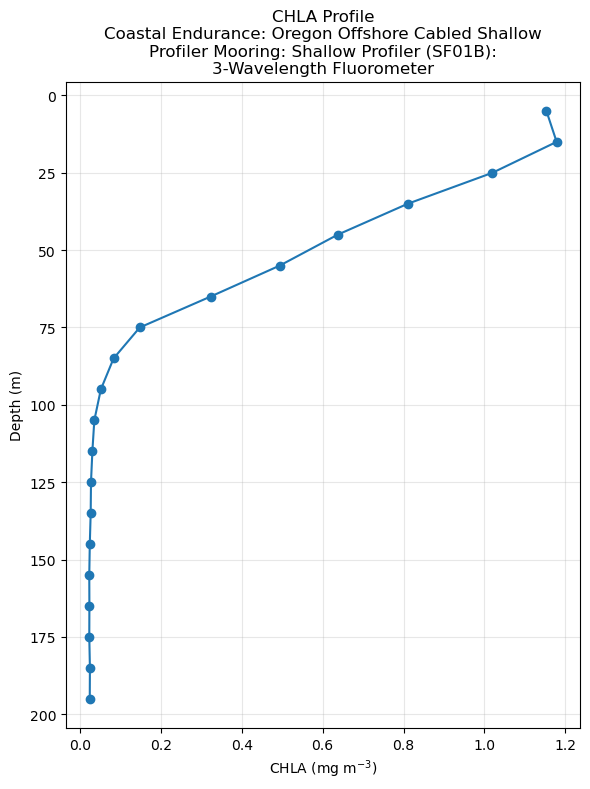

In [45]:
# Create a plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import textwrap

# ---- 1. Load combined dataset ----
combined_path = Path("_temp_data/endurance_chla_0_200m.parquet")
df = pd.read_parquet(combined_path)

# Ensure time is datetime (not strictly needed for the plot, but nice to have)
df["time"] = pd.to_datetime(df["time"])

# ---- 2. Identify CHLA columns and pick a good profile ----
chla_cols = [c for c in df.columns if c.startswith("CHLA_")]

if not chla_cols:
    raise ValueError("No CHLA_ columns found in the dataframe.")

# Count how many non-NaN CHLA values each profile_id has (per row)
# (Assumes one row per profile_id; if multiple, takes the max across rows.)
counts = (
    df.groupby("profile_id")[chla_cols]
      .apply(lambda x: x.notna().sum(axis=1).max())
)

# Get a profile_id with at least 10 valid CHLA bins
valid_profiles = counts[counts >= 10]
if valid_profiles.empty:
    raise ValueError("No profile_id found with at least 10 non-NaN CHLA bins.")

rand_row = valid_profiles.sample(1, random_state=None)  # set an int seed if you want reproducible

profile_id = rand_row.index[0]
n_bins = rand_row.iloc[0]

print(f"Using profile_id: {profile_id} with {n_bins} valid CHLA bins")

# Get Description
desc = df.loc[df["profile_id"] == profile_id, "description"].iloc[0]

# ---- 3. Extract that profile ----
sub = df[df["profile_id"] == profile_id].copy()

# If there somehow are multiple rows for this profile, average them
if len(sub) > 1:
    sub = sub.groupby("profile_id")[chla_cols].mean().reset_index()
else:
    sub = sub.reset_index(drop=True)

# Take the first (or only) row of CHLA values
chla_vals = sub[chla_cols].iloc[0].values

# ---- 4. Build depth midpoints from CHLA_0_10 style column names ----
# CHLA_0_10 -> lower edge = 0 -> midpoint = 5
depths = []
for col in chla_cols:
    # col format assumed: "CHLA_<z1>_<z2>"
    parts = col.split("_")
    if len(parts) < 3:
        raise ValueError(f"Unexpected CHLA column format: {col}")
    z1 = int(parts[1])
    z_mid = z1 + 5  # 10 m bin midpoint
    depths.append(z_mid)

depths = np.array(depths)
chla_vals = np.array(chla_vals, dtype=float)

# Sort by depth (just in case columns are out of order)
order = np.argsort(depths)
depths = depths[order]
chla_vals = chla_vals[order]

# Mask out NaNs so the plot doesn't connect them
valid = ~np.isnan(chla_vals)
depths_valid = depths[valid]
chla_valid = chla_vals[valid]

# ---- 5. Plot CHLA vs depth ----
plt.figure(figsize=(6, 8))
plt.plot(chla_valid, depths_valid, marker="o")

plt.gca().invert_yaxis()  # surface at top
plt.xlabel("CHLA (mg m$^{-3}$)")
plt.ylabel("Depth (m)")
wrapped_desc = textwrap.fill(desc, width=50)  # adjust width to taste
plt.title(f"CHLA Profile\n{wrapped_desc}")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

